In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")


Using cpu device


100%|██████████| 26421880/26421880 [00:01<00:00, 16374866.68it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 321192.26it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5517595.52it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12089740.76it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [74]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


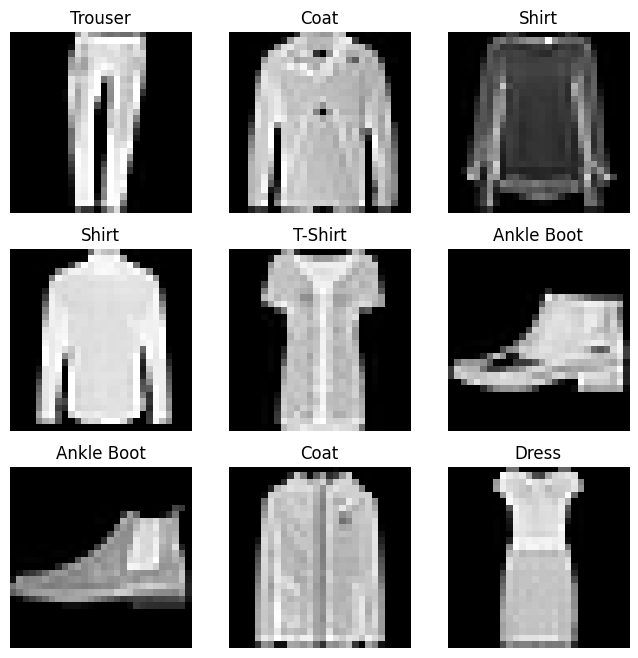

In [75]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [76]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_neurons=512,input_dim=28*28,output_dim=10):
        super(NeuralNetwork, self).__init__()

        self.conv_layer = nn.Conv2d(input_dim, 16, kernel_size=5, stride=1)

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 300),
            nn.ReLU(),
            nn.Linear(300, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, output_dim),
            
        )
        
      

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x

model = NeuralNetwork(n_neurons=512)
print(model)

NeuralNetwork(
  (conv_layer): Conv2d(784, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [77]:
learning_rate = 1e-3
batch_size = 64
epochs = 5
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [78]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss}  [{current}/{size}]")


def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
def predict(data,model,apply_softmax=True):
    labels=data[1]
    label=labels[0] #Take first element of batch
    data=data[0]  
    data=data[0,:,:,:] #Take first element of batch
    print(f"Size of one sample is {data.size()}") #First dimension is 1 because image is black & white. Would be 3 for RGB.
    pred = model(data)
    if apply_softmax:
        softmax=nn.Softmax()
        pred=softmax(pred)
    pred=pred.detach().numpy()
    pred=pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")

In [79]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
    print('Validation results:')
    predict_dataset(validation_dataloader, model, loss_fn)
print('Test results:')
predict(next(iter(test_dataloader)),model,loss_fn)
predict_dataset(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.301104784011841  [0/40000]
loss: 2.301204204559326  [6400/40000]
loss: 2.2956013679504395  [12800/40000]
loss: 2.294001579284668  [19200/40000]
loss: 2.2880821228027344  [25600/40000]
loss: 2.2872354984283447  [32000/40000]
loss: 2.281344413757324  [38400/40000]
Validation results:
Error: 
 Accuracy: 14.04%, Avg loss: 2.280312179759809 

Epoch 2
-------------------------------
loss: 2.283121347427368  [0/40000]
loss: 2.2788479328155518  [6400/40000]
loss: 2.2724802494049072  [12800/40000]
loss: 2.270655393600464  [19200/40000]
loss: 2.2694168090820312  [25600/40000]
loss: 2.2620770931243896  [32000/40000]
loss: 2.2595036029815674  [38400/40000]
Validation results:
Error: 
 Accuracy: 22.18%, Avg loss: 2.2542013195669575 

Epoch 3
-------------------------------
loss: 2.2592544555664062  [0/40000]
loss: 2.2489919662475586  [6400/40000]
loss: 2.2403011322021484  [12800/40000]
loss: 2.2383103370666504  [19200/40000]
loss: 2.241950273513794  [

<ipython-input-78-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)


Error: 
 Accuracy: 36.8%, Avg loss: 2.0512250274609607 



**Change, add or remove some layers in the model and observe training and test errors**

*   Basic: Error: 
 Accuracy: 61.58%, Avg loss: 1.397617993840746 
*   With softmax(): If its the last layer, with softmax(dim=1), it wouldnt help, as Error: 
 Accuracy: 25.180000000000003%, Avg loss: 2.2974289602534785 
*   Simple adding sigmoid to the middle wouldnt help either as: Error: 
 Accuracy: 23.57%, Avg loss: 2.2867543469568727 



(flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

With this



```
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)
```



The follwoing was the result:



```
Validation results:
Error: 
 Accuracy: 34.870000000000005%, Avg loss: 2.282150926104017 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [10.403863  9.585341 10.381373  9.653863 10.669979  9.57655  10.052623
  9.856071 10.185421  9.634916]
True label for first image is 2
<ipython-input-19-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 35.199999999999996%, Avg loss: 2.2815740032560505 
```



**With droputs:**



```
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)



Validation results:
Error: 
 Accuracy: 63.89%, Avg loss: 0.9880123009347612 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 6.365937    7.1140847  12.027325   18.21258    35.39263     0.3250821
 15.869234    0.10041037  4.528075    0.06464364]
True label for first image is 0
<ipython-input-26-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 62.8%, Avg loss: 0.9935937110026172
```
With 8 epocs. the Avg loss improved, the acc couldnt.




With the commented softmax implemented, we could imporve the results:


```
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=None)
)

Validation results:
Error: 
 Accuracy: 63.89%, Avg loss: 0.9880123009347612 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 6.365937    7.1140847  12.027325   18.21258    35.39263     0.3250821
 15.869234    0.10041037  4.528075    0.06464364]
True label for first image is 0
<ipython-input-26-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 62.8%, Avg loss: 0.9935937110026172
```
still 8 epocs was implied.



**Best results so far:**



```
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

alidation results:
Error: 
 Accuracy: 63.160000000000004%, Avg loss: 1.4379500735337567 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [16.194872  29.63511    7.3501706 21.523657   8.702003   1.8082654
  9.431145   1.071187   2.7174044  1.5661845]
True label for first image is 1
<ipython-input-38-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 63.22%, Avg loss: 1.441384177299062 
```





**I've tried a convolution layer, which gave the sam results as seem before**


```
Validation results:
Error: 
 Accuracy: 61.77%, Avg loss: 1.4219641586777512 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 6.159637   4.9429483  9.284687   6.256746   9.486445  11.006233
  8.43542   11.334328  15.685121  17.408436 ]
True label for first image is 9
<ipython-input-59-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 61.92999999999999%, Avg loss: 1.418160141653316 

 with the layers being:

 NeuralNetwork(
  (conv_layer): Conv2d(784, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
```



**Peek, with removing a layer, from initial model, and adding a plus convolution layer, 67%**

```
Validation results:
Error: 
 Accuracy: 67.46%, Avg loss: 1.0709500719027913 

Test results:
Size of one sample is torch.Size([1, 28, 28])
Predicted label probabilities for first image: [ 7.241548   3.1351824 23.72568    6.5804443 20.88199    4.870869
 15.863623   2.9813309 11.074748   3.6445801]
True label for first image is 2
<ipython-input-65-df27bb7a993a>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred=softmax(pred)
Error: 
 Accuracy: 67.49000000000001%, Avg loss: 1.078503315615806 


 NeuralNetwork(
  (conv_layer): Conv2d(784, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
```



**Other methods I've tried:**


1.   nn.Sigmoid() , worsen the cases in this context
2.   channging the parameters of nn.Linear(), instead of n_neurons, to a given constants smaller than that. Did not help, worsen msot cases.

